In [19]:
from samples_2 import hash_to_key, hash_selfie, getHashes, create_wav_spectra, getQED
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors, Descriptors, DataStructs, AllChem
import selfies
from music21.note import Note
from music21.chord import Chord
from music21.stream import Stream
from music21 import key as kyy
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import matplotlib as mpl
from sklearn.manifold import TSNE

In [2]:
keys = ["G","C","D","A","Db","F","Ab","E","Bb","F#","B","Eb"]
key_to_midi = {"C":48, "Db":49, "D": 50, "Eb":51, "E":52, "F":53, "F#":54, "G":55, "Ab":56, "A":57, "Bb":58, "B":59}
hashes, note_to_shift, major_scale, shift_to_note, valid_selfies_for_model = getHashes()

def create_midi_file(smiles, filename, directory="test", chords=True):
    ml = Chem.MolFromSmiles(smiles)
    Chem.SanitizeMol(ml)
    selfie = selfies.encoder(Chem.MolToSmiles(ml))
    print(selfie)

    key = hash_to_key(hash_selfie(selfie), np.min(hashes), np.max(hashes), keys)
    note_pattern = []
    for tkn in selfies.split_selfies(selfie):
        note_pattern.append(note_to_shift[tkn])
    print(key)
    stream = Stream()
    stream.keySignature = kyy.Key(key, 'major')
    pitches = []
    for i,k in enumerate(note_pattern):
        pitch = key_to_midi[key] + k
        pitches.append(pitch)
        if chords:
            if i%4 == 0:
                chord = []
                idx = major_scale.index(k)
                chord.append(pitch)
                chord.append(key_to_midi[key]+major_scale[idx+2])
                chord.append(key_to_midi[key]+major_scale[idx+4])
                stream.append(Chord(chord, type='eighth'))
            else:
                stream.append(Note(pitch, type='eighth'))
        else:
            stream.append(Note(pitch, type='eighth'))
    stream.write('midi', directory+ '/' + str(filename) + ".mid")

[C][C][C@expl][C][=C][C][N][C][C][C@expl][Branch2_1][Ring1][O][C][Branch1_2][=N][=C][Branch1_1][Branch1_3][C][Branch1_2][C][=O][O][C][C][Ring1][#C][N][C][=C][C][=C][C][=C][Ring1][Branch1_2][Ring1][#C][C@@Hexpl][Ring2][Ring1][Ring1][Ring2][Ring1][Branch1_3]
G
FluidSynth runtime version 2.3.1
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'wav/9.wav'..


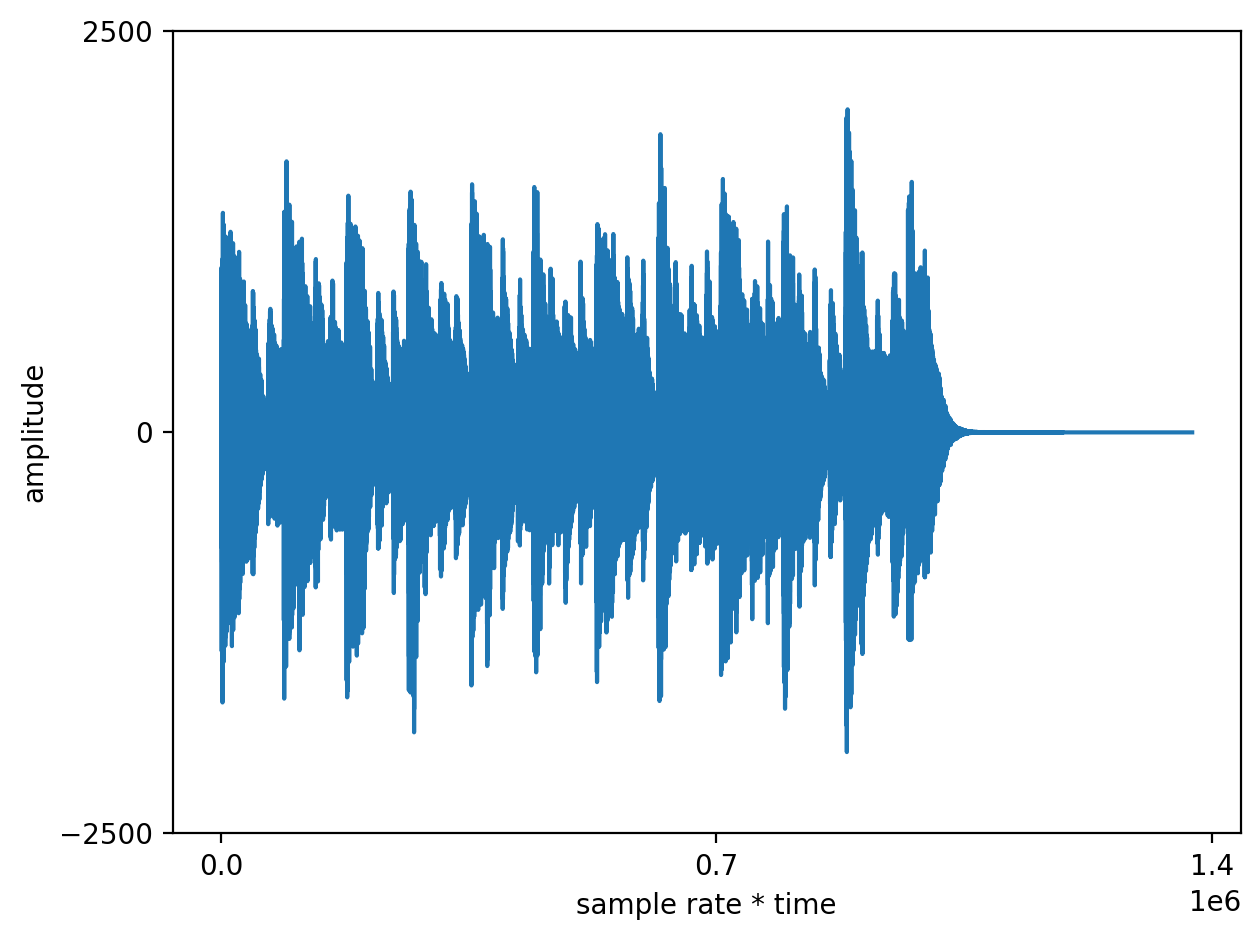

In [3]:
# part 1 - smiles to midi and wav

smiles =  "CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5" #@param
filename = "9" #@param

create_midi_file(smiles, filename)
os.system("fluidsynth -ni FatBoy-v0.790.sf2 test/"+filename+".mid -F wav/"+filename+".wav -r 44100")
create_wav_spectra(filename)

In [4]:
# part 2 - modifying music to make new molecules

mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']

input_mel_midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob('./test/9.mid'))]
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]

In [5]:
print("original\n", smiles)
gen, keys_map, streams = [], [], []
for j in key_to_midi:
    nts, nts_w_chrd = [], []
    not_valid = False
    n = 0
    for i,k in enumerate(mel_input_seqs[0].notes):
        note_number = 41 #@param {type:"slider", min:-1, max:55, step:1}
        set_note = 4 #@param {type:"slider", min:-1, max:31, step:1}

        if n == 1 or n == 2: 
            n = n + 1
            nts_w_chrd.append(k.pitch)
            continue 
        n = n + 1

        shft = k.pitch - key_to_midi[j]
        if shft not in shift_to_note:
            not_valid = True
            break

        if i == note_number and note_number > -1 and set_note > -1: 
            print("changing:" + shift_to_note[shft] + " to " + \
                shift_to_note[major_scale[set_note]] + " at note " + str(note_number) + \
                " for key " + j)
            shft = major_scale[set_note]
            nts_w_chrd.append(key_to_midi[j]+shft)
        else:
            nts_w_chrd.append(k.pitch)
        nts.append(shft)

    if n == 6: n = 0

    if not_valid: continue
    else:
        keys_map.append(j)
        gen.append(nts)

        stream = Stream()
        stream.keySignature = kyy.Key(j, 'major')
        chord = []
        n = 0
        for i,k in enumerate(nts_w_chrd):
            if n < 3:
                chord.append(k)
                n = n + 1
            if n == 3:
                stream.append(Chord(chord,type='eighth'))
                n = n + 1
                continue
            if n > 3 and n < 7:
                stream.append(Note(k,type='eighth'))
                n = n + 1
            if n == 7:
                chord = []
                n = 0
        streams.append(stream)
        stream.write('midi', 'test/morphD.mid')

print("decoded")
for i,k in enumerate(gen):
    se = []
    for j in k: se.append(shift_to_note[j])
    sel = "".join(se)
    ke = hash_to_key(hash_selfie(sel), np.min(hashes), np.max(hashes), keys)
    if ke == keys_map[i]:
        print(selfies.decoder(sel), ke)
        streams[i].write('midi',"morphed.mid")
        try:
            mol = Chem.MolFromSmiles(selfies.decoder(sel))
            Chem.SanitizeMol(mol)
        except:
            print("failed")
            
img = Draw.MolToImage(mol)
img.save("./decoded.png",format="PNG")

original
 CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5
changing:[#C] to [O] at note 41 for key G
decoded
C1C[C@]C=C1CNCC([C@]2(N=NC))(C3([C@H])C=O)OC3(C2N=CC=C)C=C=O G


In [6]:
# part 3 - musicVAE interpolation


mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path='./model/model.ckpt-10429')

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
    """Interpolates between a start and end sequence."""
    note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

    return note_sequences

def seq_to_smiles(seq):
    decoded = {}
    for j in key_to_midi:
        se = []
        for k in seq.notes:
            shift = k.pitch - key_to_midi[j]
            if shift in shift_to_note:
                se.append(shift_to_note[shift])
        decoded[j] = selfies.decoder("".join(se))
    return decoded

input_mel_midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob('./test/*.mid'))]
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
    extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
files = [fn for fn in sorted(tf.io.gfile.glob('./test/*.mid'))]

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.la

/Users/bmahjour/Documents/Projects/samples_review_response/magenta/magenta/models/music_vae/lstm_utils.py:94: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  tf.layers.dense(
/Users/bmahjour/Documents/Projects/samples_review_response/magenta/magenta/contrib/rnn.py:749: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._kernel = self.add_variable(
/Users/bmahjour/Documents/Projects/samples_review_response/magenta/magenta/contrib/rnn.py:751: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._bias = self.add_variable(


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-10429


/Users/bmahjour/Documents/Projects/samples_review_response/magenta/magenta/models/music_vae/base_model.py:195: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mu = tf.layers.dense(
/Users/bmahjour/Documents/Projects/samples_review_response/magenta/magenta/models/music_vae/base_model.py:200: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  sigma = tf.layers.dense(
2023-02-16 17:32:37.315980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-16 17:32:37.318485: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


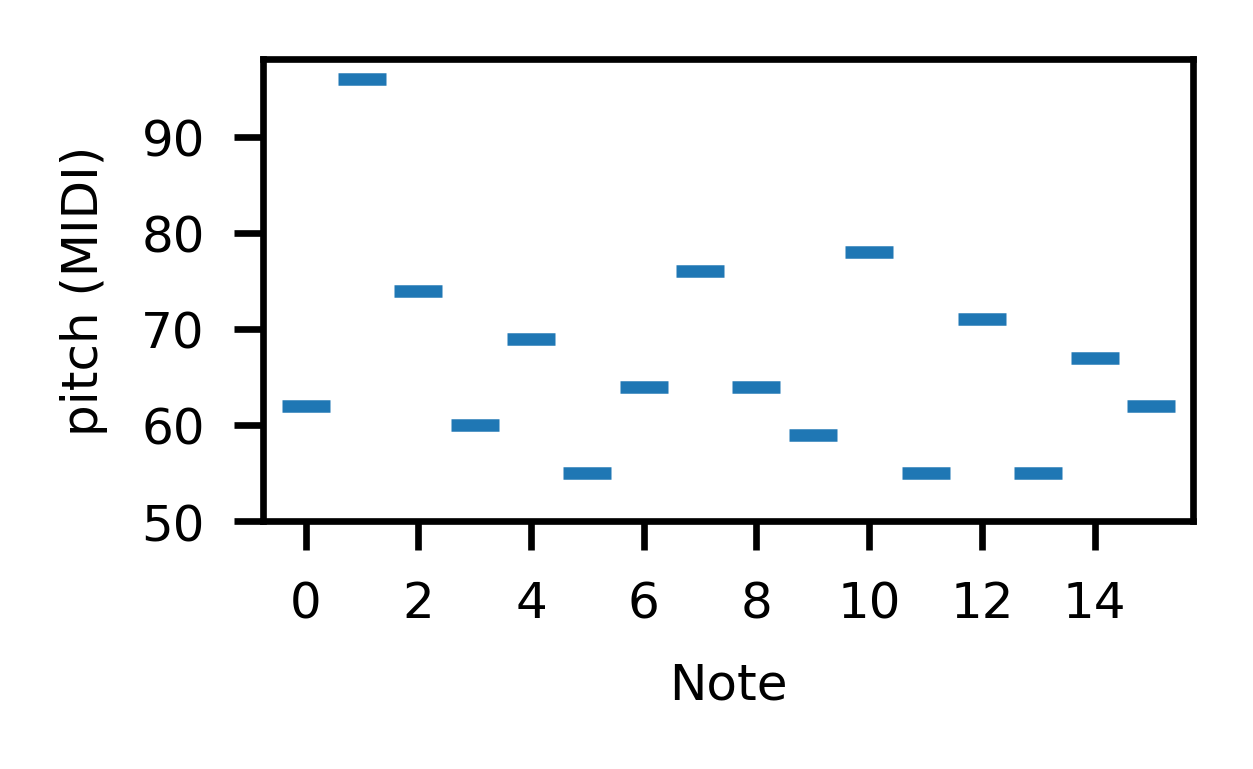

OC[C@@H](NOCC)OC
O=O
OC[C@@]C(=O)[C@@]COC(=O)


In [7]:
i1 = 0
i2 = 1
start_mel = extracted_mels[i1]
end_mel = extracted_mels[i2]
temperature = .1
num_steps =  3

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

x = []
y = []
fig, ax = plt.subplots(figsize=(2,1), dpi=300)

for i,k in enumerate(start_mel.notes):
    x.append(i)
    y.append(k.pitch)
  
ax.scatter(x,y, marker='_', s=32)
ax.set_xlabel("Note", fontsize=6)
ax.set_ylabel("pitch (MIDI)", fontsize=6)
ax.set_yticks([50,60,70,80,90])
ax.set_yticklabels(ax.get_yticks(), fontsize=6)
ax.set_xticks(range(0,16,2))
ax.set_xticklabels(ax.get_xticks(), fontsize=6)
plt.show()

for k in mel_2bar_interp:
    out = seq_to_smiles(k)
    print(out["G"])

G 7951 0.5729580314357605
C 901 0.17902843840761887
D 124 0.04962847975898997
A 37 0.02457646657965332
Db 9 0.012694743279173519
F 5 0.014613457255083404
Ab 1 0.0095786091091358
E 3 0.012019072882484676
F# 1 0.0096257262911143
Eb 1 0.015742586341330838


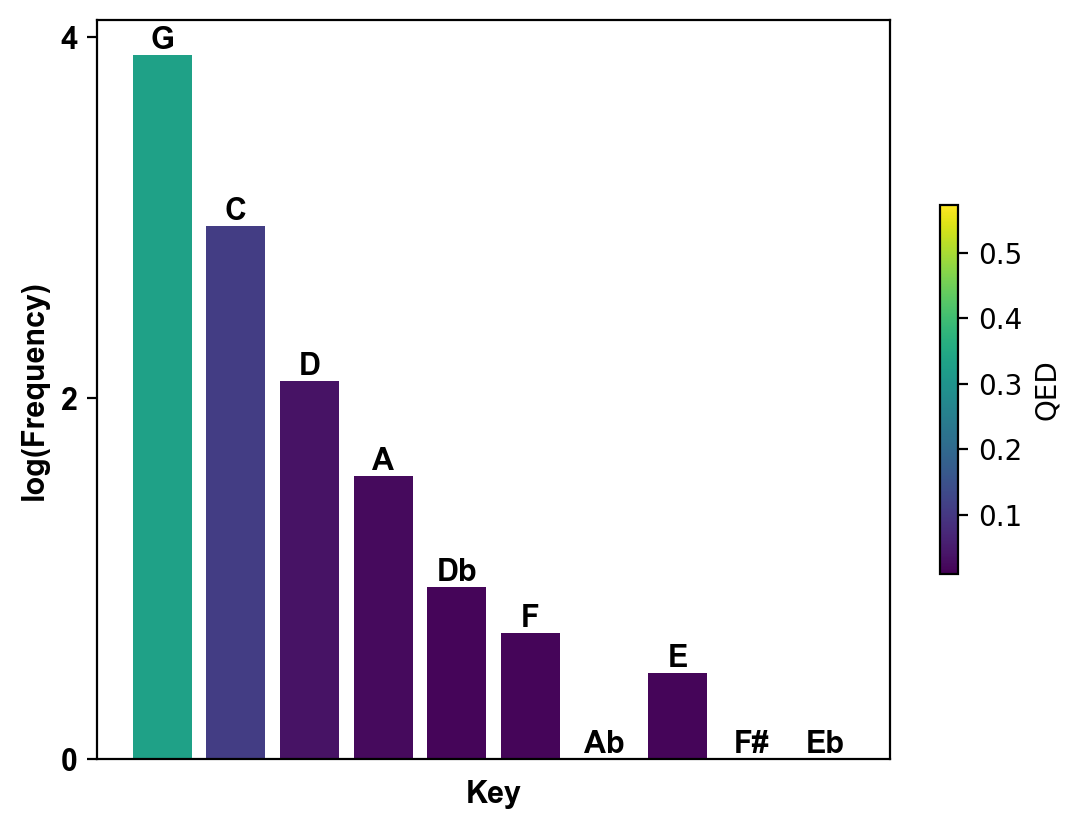

In [14]:
# part 4 - informatics

key_count = {i:0 for i in keys}
qed_by_key = {i:[] for i in keys}
for k in valid_selfies_for_model:
    key = hash_to_key(hash_selfie(k), np.min(hashes), np.max(hashes), keys)
    key_count[key] += 1
    qed = getQED(Chem.MolFromSmiles(selfies.decoder(k)))
    qed_by_key[key].append(qed)

cmap=plt.get_cmap("viridis")

bars = []
cols = []
labels = []
qeds = []
for k in key_count:
    if key_count[k] > 0:
        print(k, key_count[k], np.mean(qed_by_key[k]))
        bars.append(key_count[k])
        cols.append(cmap(np.mean(qed_by_key[k])))
        qeds.append(np.mean(qed_by_key[k]))
        labels.append(k)

bar1 = plt.bar(range(0,len(bars)),np.log10(bars), color=cols)
plt.xticks(range(0,len(bars)), labels, fontsize=6, fontname="arial")
plt.xticks([])
plt.xlabel("Key", fontsize=11, fontname="arial",weight='bold')
plt.yticks([0,2,4],fontsize=11, fontname="arial",weight='bold')
plt.ylabel("log(Frequency)", fontsize=11, fontname="arial",weight='bold')
for i,rect in enumerate(bar1) :
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, labels[i], fontsize=11, fontname="arial",ha='center', va='bottom',weight='bold')
# plt.xtickl
norm = mpl.colors.Normalize(vmin=np.min(qeds), vmax=np.max(qeds))

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='QED', shrink=.5)
plt.savefig("graph.png",dpi=300)

In [17]:
drug_keys = []
fps = []
valid_smiles = []
for k in valid_selfies_for_model:
    key = hash_to_key(hash_selfie(k), np.min(hashes), np.max(hashes), keys)
    drug_keys.append(key)
    mol = Chem.MolFromSmiles(selfies.decoder(k))
    valid_smiles.append(Chem.MolToSmiles(mol))
    nfp = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 2,nBits=512), nfp)
    fps.append(nfp)

In [21]:
X = TSNE(n_components=2, n_jobs=-1).fit_transform(np.array(fps))

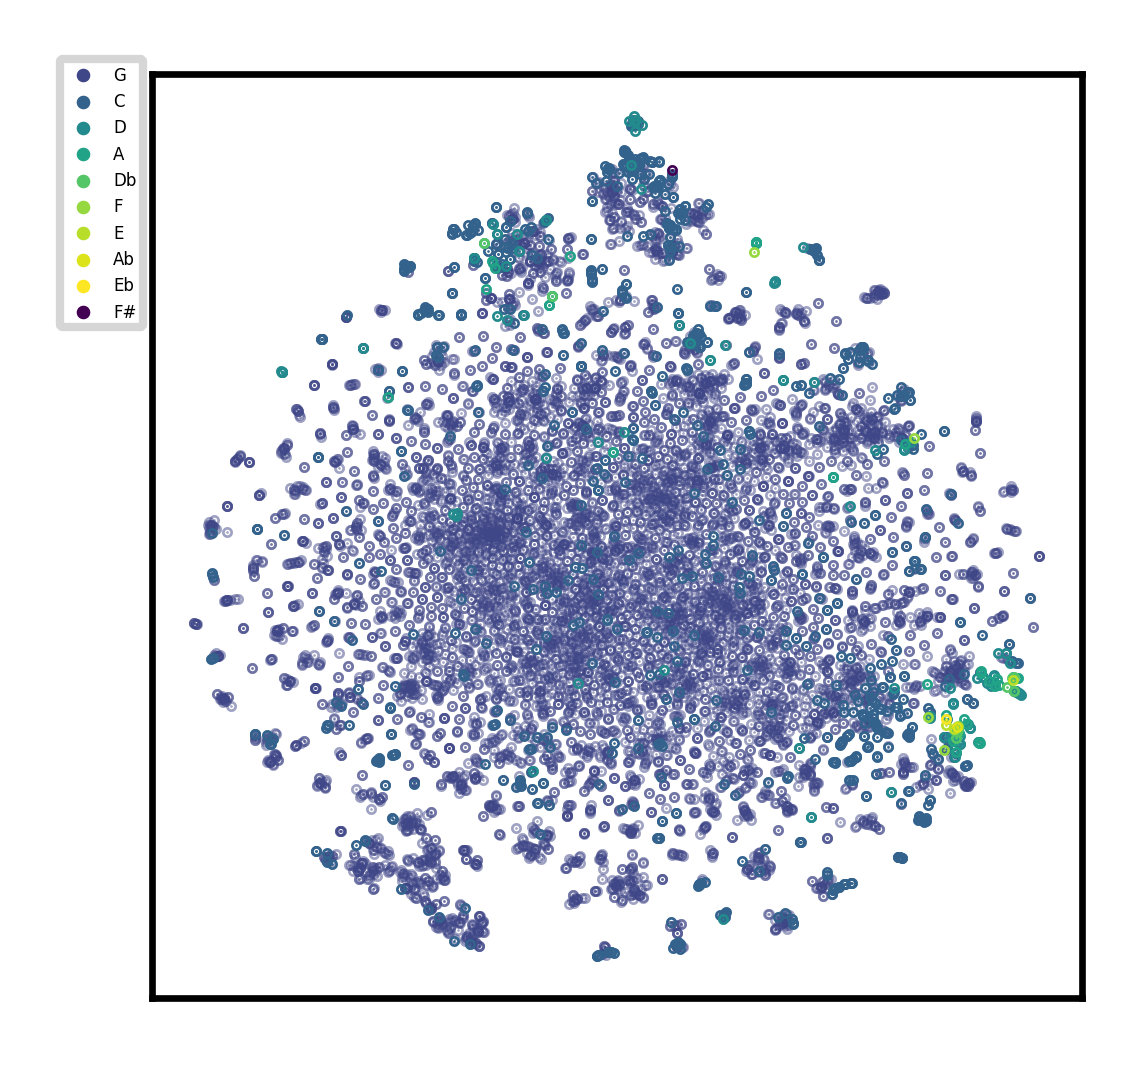

In [23]:
drug_keys_one_hot = []
buckets = {}
for i,k in enumerate(drug_keys):
  # print(keys.index(k))
    if k not in buckets:
        buckets[k] = []
    buckets[k].append(X[i])

    drug_keys_one_hot.append(keys.index(k))

buckets_sort = sorted(buckets, key=lambda k: len(buckets[k]), reverse=True)

fig, ax = plt.subplots(figsize=(2,2), dpi=300)
colors = ["#404788", "#33638D", "#238A8D", "#20A387", "#55C667", "#95D840", "#B8DE29", "#DCE319", "#FDE725","#440154"]
n = 0
for i,k in enumerate(buckets_sort):
  if i == 0:
    alpha = .5
  else:
    alpha = 1
  ax.scatter(np.array(buckets[k])[:,0],np.array(buckets[k])[:,1], cmap='plasma', s=.1, alpha=alpha, color=colors[i], label=k, zorder=n)
  n = n + 1

ax.set_xticks([])
ax.set_yticks([])

leg = ax.legend(bbox_to_anchor=(-0, 1.025), fontsize=2, markerscale=2)
for legend_handle in leg.legendHandles:
    legend_handle.set_alpha(1)

plt.show()

In [28]:
# part 5 - music to molecule

notes2 = [60, 60, 67, 67, 69, 69, 67, 65, 65, 64, 64, 62, 62, 60, \
         67, 67, 65, 65, 64, 64, 62, 67, 67, 65, 65, 64, 64, 62]
notes = []
for j in notes2:
    notes.append(j)
key = key_to_midi["Db"]
se = []
shifts = []
for k in notes:
    if int(k-key) not in shift_to_note:
        if k == 62:
            se.append("[Ring2]")
        if k == 64:
            se.append("[C]")
        if k == 67:
            se.append("[Branch2_1]")
        continue
    shifts.append([k-key])
    se.append(shift_to_note[k-key])
selfies.decoder("".join(se))



'N12N([C@H][C@H]CC1([C@H]CC2[C@H][C@H]C=C))'